In [1]:
#Device check out
!nvidia-smi

Thu Jul 25 06:32:35 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
#Library imports
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
import cv2
from tqdm import tqdm
%matplotlib inline
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.mobilenet import preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D
!pip install kaggle
!pip install livelossplot
from livelossplot.keras import PlotLossesCallback
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


^C


In [0]:
!mkdir .kaggle
!mkdir /root/.kaggle

In [5]:
!ls .kaggle

kaggle.json


In [0]:
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c aptos2019-blindness-detection

In [9]:
!ls /content/

sample_data	       test.csv		train.csv
sample_submission.csv  test_images.zip	train_images.zip


In [12]:
#Directories preparation, unziping training and testing files

!mkdir test_images
!mkdir train_images

!mkdir validation_images
!mkdir validation_images/No_DR
!mkdir validation_images/Mild
!mkdir validation_images/Moderate
!mkdir validation_images/Severe
!mkdir validation_images/Proliferative_DR

!mkdir train_images/No_DR
!mkdir train_images/Mild
!mkdir train_images/Moderate
!mkdir train_images/Severe
!mkdir train_images/Proliferative_DR

import shutil
shutil.move("/content/test_images.zip", "/content/test_images/test_images.zip")
shutil.move("/content/train_images.zip", "/content/train_images/test_images.zip")

!unzip /content/test_images/test_images.zip -d /content/test_images/
!unzip /content/train_images/test_images.zip -d /content/train_images/

'/content/train_images/test_images.zip'

In [15]:
#Preparation of training data classification

base_image_dir = os.path.join('..', '/content/')
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,diagnosis,path
0,2,/content/train_images/d4be0403e6ab.png
1,0,/content/train_images/75238d945315.png
2,0,/content/train_images/11b220a397b8.png
3,2,/content/train_images/ceb601fe8dba.png
4,2,/content/train_images/475c7ded0f7a.png
5,2,/content/train_images/b0d35981708b.png
6,0,/content/train_images/3580a545016d.png
7,0,/content/train_images/50916d67bb51.png
8,3,/content/train_images/070f67572d03.png
9,0,/content/train_images/3b5dffe159b6.png


In [16]:
#Number of training images

len_df = len(df)
print(f"There are {len_df} images")

There are 3662 images


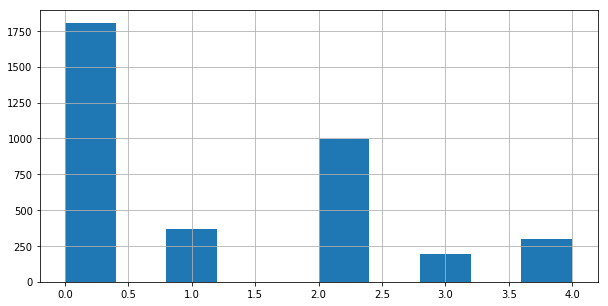

In [17]:
#Training data classes visualization

df['diagnosis'].hist(figsize = (10, 5))

In [0]:
#Relocating of training photos (70% of all training photos)
for i in range(0, 2562):
  if df.at[i, 'diagnosis'] == 0:
    core_file = df.at[i, 'path']
    shutil.move(df.at[i, 'path'], "/content/train_images/No_DR/" + core_file[22:])
  elif df.at[i, 'diagnosis'] == 1:
    core_file = df.at[i, 'path']
    shutil.move(df.at[i, 'path'], "/content/train_images/Mild/" + core_file[22:])    
  elif df.at[i,'diagnosis'] == 2:
    core_file = df.at[i, 'path']
    shutil.move(df.at[i, 'path'], "/content/train_images/Moderate/" + core_file[22:])    
  elif df.at[i, 'diagnosis'] == 3:
    core_file = df.at[i, 'path']
    shutil.move(df.at[i, 'path'], "/content/train_images/Severe/" + core_file[22:])    
  elif df.at[i, 'diagnosis'] == 4:
    core_file = df.at[i, 'path']
    shutil.move(df.at[i, 'path'], "/content/train_images/Proliferative_DR/" + core_file[22:]) 
    

In [0]:
#Relocating of validation photos (30% of all training photos)
for i in range(2562, len_df):
  if df.at[i, 'diagnosis'] == 0:
    core_file = df.at[i, 'path']
    shutil.move(df.at[i, 'path'], "/content/validation_images/No_DR/" + core_file[22:])
  elif df.at[i, 'diagnosis'] == 1:
    core_file = df.at[i, 'path']
    shutil.move(df.at[i, 'path'], "/content/validation_images/Mild/" + core_file[22:])    
  elif df.at[i,'diagnosis'] == 2:
    core_file = df.at[i, 'path']
    shutil.move(df.at[i, 'path'], "/content/validation_images/Moderate/" + core_file[22:])    
  elif df.at[i, 'diagnosis'] == 3:
    core_file = df.at[i, 'path']
    shutil.move(df.at[i, 'path'], "/content/validation_images/Severe/" + core_file[22:])    
  elif df.at[i, 'diagnosis'] == 4:
    core_file = df.at[i, 'path']
    shutil.move(df.at[i, 'path'], "/content/validation_images/Proliferative_DR/" + core_file[22:]) 

In [0]:
#Plot function to visualise images
def plot_images(item_dir, top=25):
  all_item_dirs = os.listdir(item_dir)
  item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:top]

  plt.figure(figsize = (12,12))
  for idx, img_path in enumerate(item_files):
    plt.subplot(5,5, idx+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
  plt.tight_layout()

In [23]:
train_len = len(os.listdir('/content/train_images/'))
test_len = len(os.listdir('/content/test_images/'))

print("Number of cases (train): ", train_len)
print("Number of cases (test): ", test_len)

Number of cases (train):  6
Number of cases (test):  1929


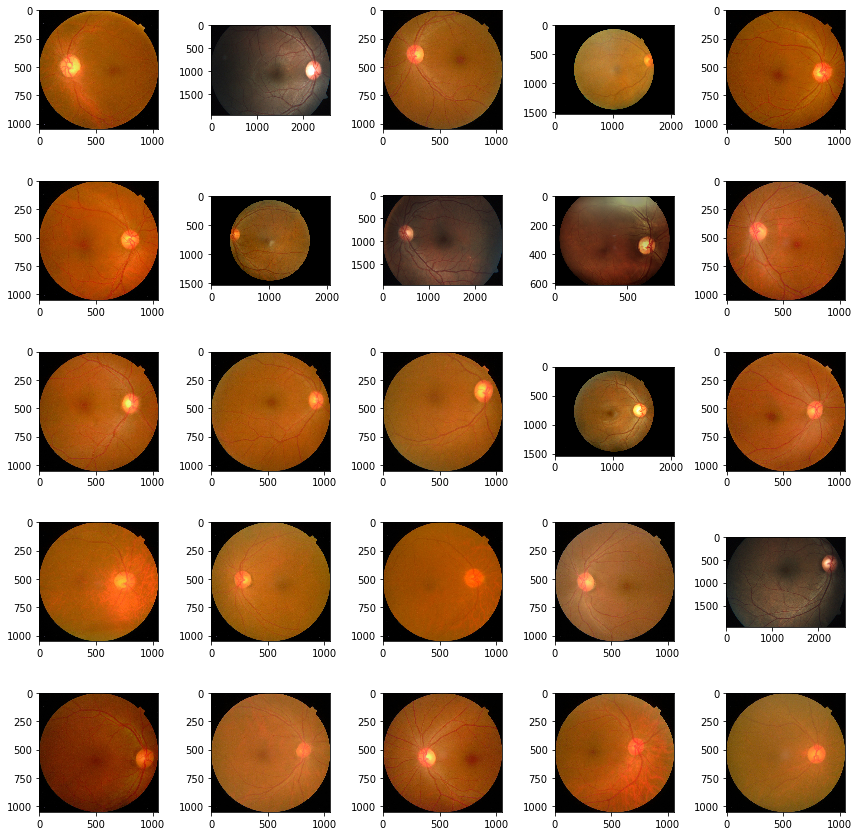

In [24]:
#NO_DR Class Images
plot_images("/content/train_images/No_DR")

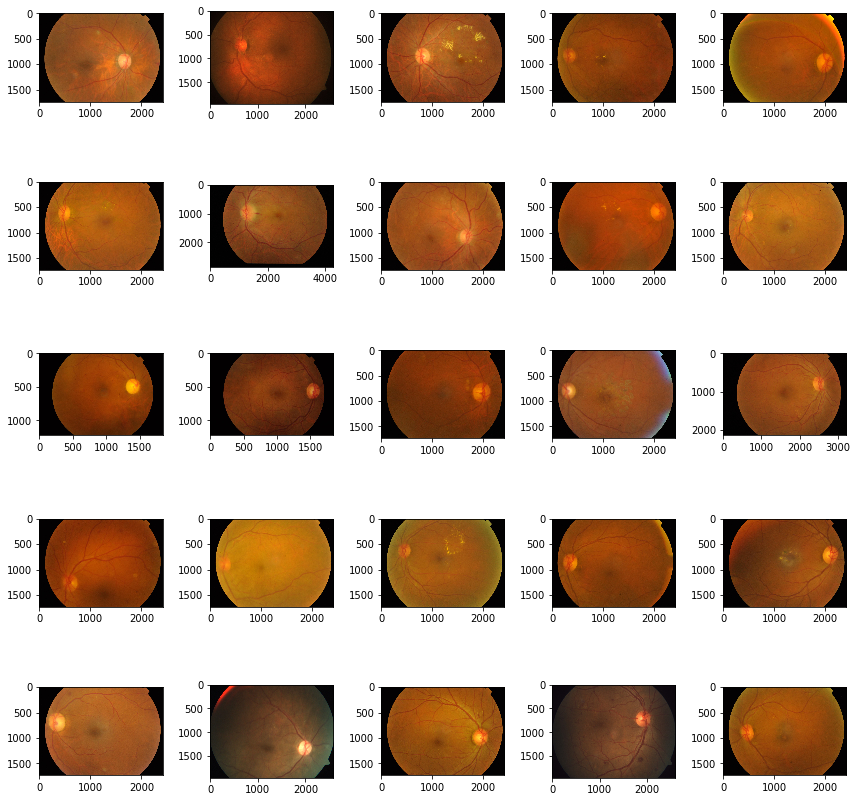

In [25]:
#Mild Class Images
plot_images("/content/train_images/Mild")

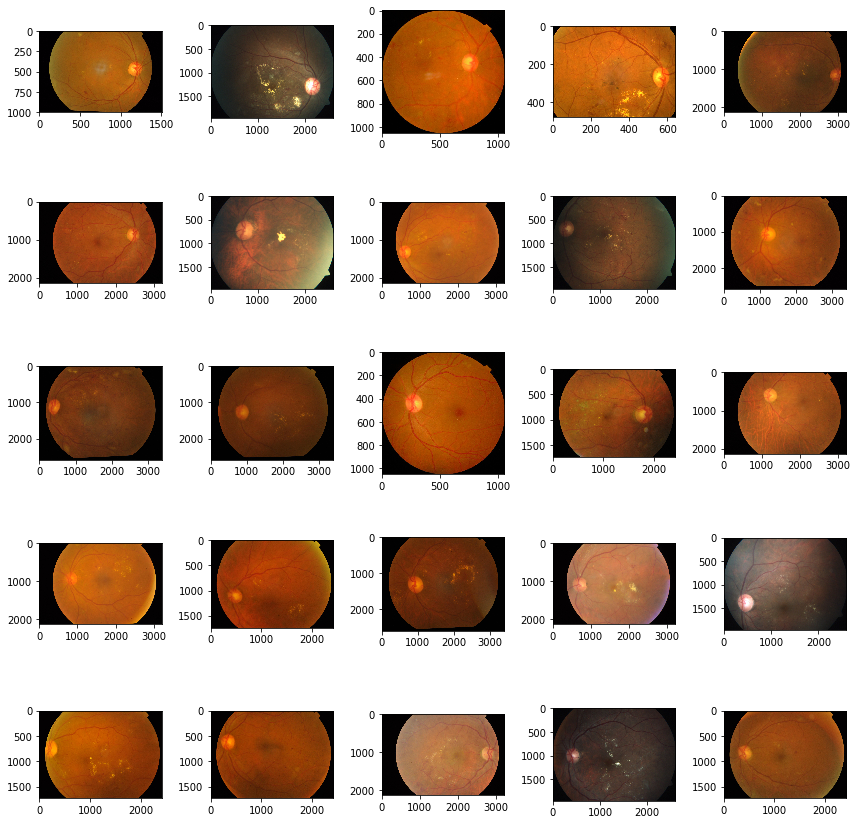

In [26]:
#Moderate Class Images
plot_images("/content/train_images/Moderate")

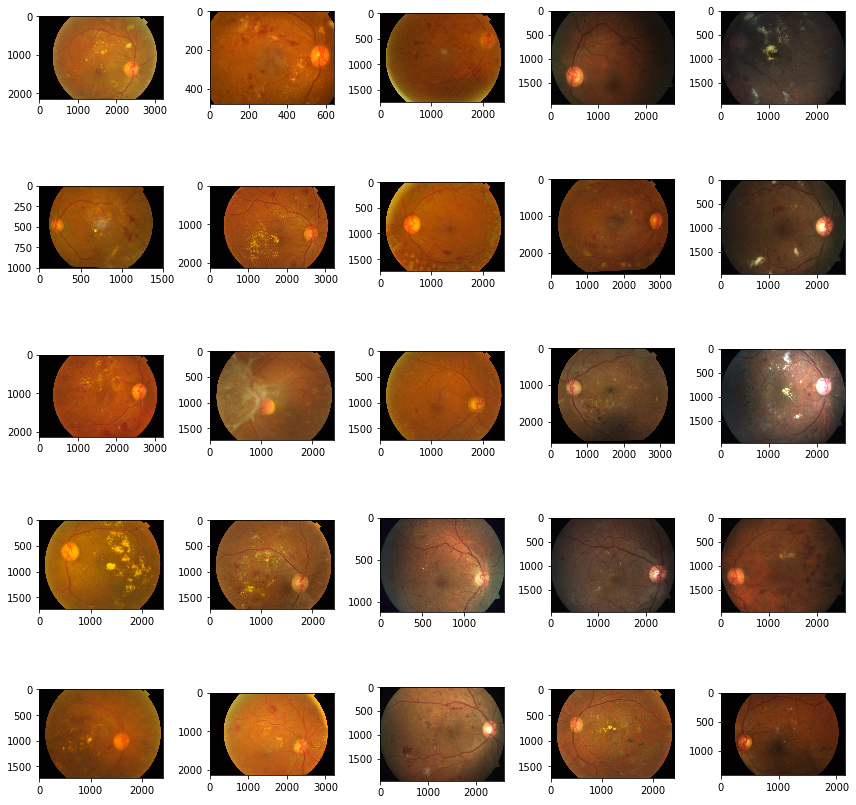

In [27]:
#Severe Class Images
plot_images("/content/train_images/Severe")

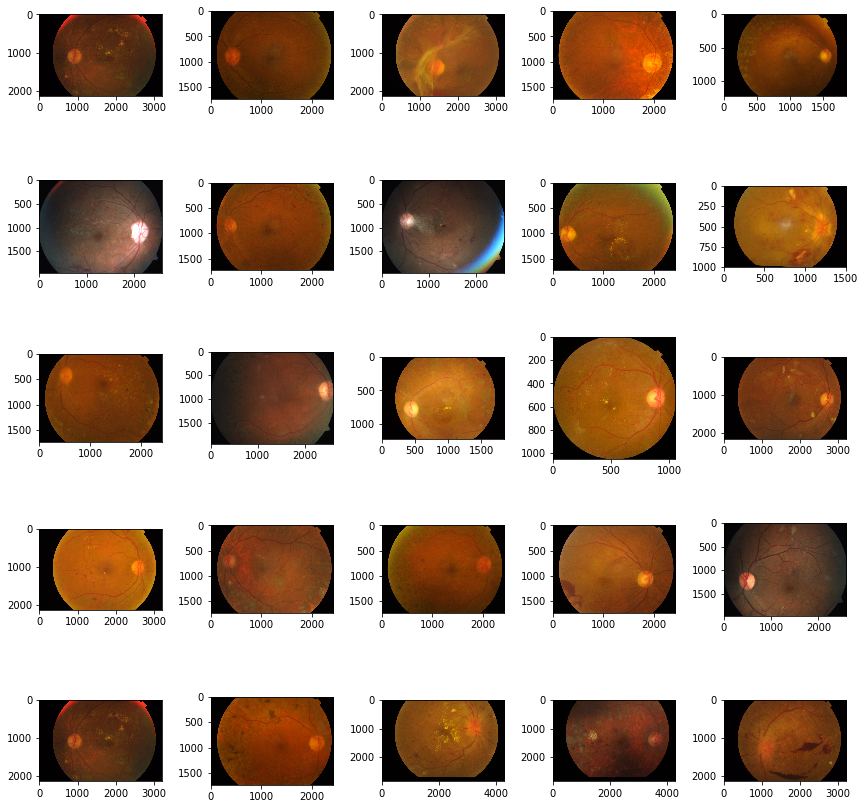

In [28]:
#Proliferative_DR Class Images
plot_images("/content/train_images/Proliferative_DR")

In [29]:
#Importing training scans of the data set as a basics to train Keras model, training generator contains two type of flips and another 3 extra preprocessing functions

train_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    horizontal_flip=True, 
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.5
)

train_generator=train_datagen.flow_from_directory(
    '/content/train_images/',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 2562 images belonging to 5 classes.


In [30]:
#Importing validation scans of the data set
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator=val_datagen.flow_from_directory(
    '/content/validation_images/',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1100 images belonging to 5 classes.


In [32]:
#Keras Classification Model Definition

def myModel(input_shape):
   model = Sequential ([
       
    Conv2D(128, (3,3), input_shape=input_shape),
    MaxPool2D((3,3)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((3,3)),
    
    Conv2D(32, (3,3), activation='relu'),   
    MaxPool2D((2,2)),
       
    Conv2D(16, (3,3), activation='relu'),   
    MaxPool2D((2,2)),
    
    Flatten(),

    Dense(2048, activation='relu'),
       
    Dropout(0.3),
       
    Dense(1024, activation='relu'),
       
    Dropout(0.5),
       
    Dense(1024, activation='relu'),
       
    Dropout(0.3),
    
    Dense(512, activation='relu'),
       
    Dropout(0.5),
       
    Dense(5, activation='sigmoid')   
]) 
   return model

input_shape = (224,224,3)

model = myModel(input_shape)

#Model Compilation
model.compile( loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 16)          4624      
__________

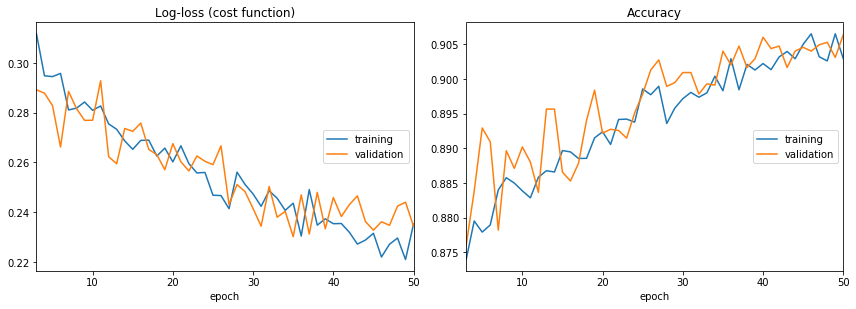

Log-loss (cost function):
training   (min:    0.221, max:    0.403, cur:    0.235)
validation (min:    0.230, max:    0.294, cur:    0.234)

Accuracy:
training   (min:    0.824, max:    0.906, cur:    0.903)
validation (min:    0.874, max:    0.906, cur:    0.906)


In [33]:
#Model training with live parameters visualisation
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=len(validation_generator),
      verbose=1,
      callbacks=[PlotLossesCallback()]
)

In [0]:
#Model weights export
model.save_weights("model.h5")

In [36]:
#Test images names preparation
submit = pd.read_csv('../content/sample_submission.csv')
submit = submit.drop(columns=['diagnosis'])
predicted = []
submit.head(10)


,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4
5,009c019a7309
6,010d915e229a
7,0111b949947e
8,01499815e469
9,0167076e7089


In [37]:
#Test images prediction
for i, name in tqdm(enumerate(submit['id_code'])):
    path = os.path.join('..//content/test_images', name+'.png')
    original = load_img(path, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    processed_image = preprocess_input(image_batch.copy())
    predict = model.predict(processed_image)
    result = np.argmax(predict)
    predicted.append(str(result))
   


1928it [01:29, 21.56it/s]


In [38]:
#Result Save
submit['diagnosis'] = predicted
submit.to_csv('submission.csv', index=False)
submit.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,1
2,006efc72b638,1
3,00836aaacf06,1
4,009245722fa4,1
